In [1]:
from snAPI.Main import *
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.optimize import curve_fit

In [2]:
class HH_T3:
    def __init__(self,sn,filename):
        sn.getDevice()
        sn.getFileDevice(filename)
        sn.initDevice(MeasMode.T3)
        self.t_resol=sn.deviceConfig['Resolution']/1000 #in ns
        sn.raw.measure()
        self.data = sn.raw.getData()
        self.channels=sn.raw.channel(self.data)
        self.dTimes=sn.raw.dTime_T3(self.data)[np.where(self.channels!=64)]*self.t_resol
        self.dataChannels=self.channels[np.where(self.channels!=64)]
        sn.unfold.measure()
        self.absTimes=sn.unfold.getData()[0]/1e3 # in ns
        self.df=pd.DataFrame(np.array([self.dTimes,self.absTimes,self.dataChannels]).T,columns=['dTimes','absTimes','Channels'])
        sn.closeDevice()
    def Gate(self,T):
        return self.df[(self.df['dTimes']>T)]
    def Counts(self,ch):
        return np.size(self.df['dTimes'][self.df['Channels']==ch]) 

In [3]:
def binned(times,t_res, t0, tf):
        edges=np.arange(t0,tf,t_res)
        return np.histogram(times,edges)
def edges2bins(edges):
    return edges[:-1]+np.diff(edges)/2

In [4]:
def model1(x,t0,alpha,tau,B):
    return np.log10(alpha*np.exp(-(x-t0)/tau)+B)
def model2(x,t0,alpha1,tau1,alpha2,tau2,B):
    return np.log10(alpha1*np.exp(-(x-t0)/tau1)+alpha2*np.exp(-(x-t0)/tau2)+B)
def model3(x,t0,alpha1,tau1,alpha2,tau2,alpha3,tau3,B):
    return np.log10(alpha1*np.exp(-(x-t0)/tau1)+alpha2*np.exp(-(x-t0)/tau2+alpha3*np.exp(-(x-t0)/tau3))+B)
def model2(x,alpha1,tau1,alpha2,tau2,B):
    return np.log10(alpha1*np.exp(-(x)/tau1)+alpha2*np.exp(-(x)/tau2)+B)


In [5]:
sn=snAPI()

In [6]:
free_0='C:/Users/NEXT-BOLD/Documents/MIKEL/Dropbox/Proyectos/data/APD/AAN155_Concentraciones3/1e-5_Filter7/Ba_degassed.ptu'

In [7]:
os.listdir(free_0)

NotADirectoryError: [WinError 267] El nombre del directorio no es válido: 'C:/Users/NEXT-BOLD/Documents/MIKEL/Dropbox/Proyectos/data/APD/AAN155_Concentraciones3/1e-5_Filter7/Ba_degassed.ptu'

In [8]:
f0=HH_T3(sn,filename=free_0)

Text(0, 0.5, 'Counts')

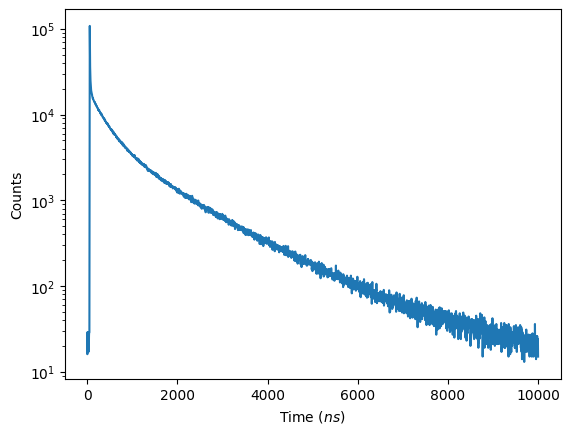

In [9]:
binning=4
countsf0,edges=binned(f0.df['dTimes'],f0.t_resol*binning,0,10000)
bins=edges2bins(edges)

plt.plot(bins,countsf0,label='Free (no filters)')

plt.yscale('log')
plt.xlabel('Time ($ns$)')
plt.ylabel('Counts')



In [10]:
n0=30
xdata0=bins[n0:]
ydata0=np.log10(countsf0[n0:])
valid = ~(np.isinf(xdata0) | np.isinf(ydata0))
xdata=xdata0[valid]
ydata=ydata0[valid]

In [11]:
popt, pcov = curve_fit(f=model2,xdata=xdata,ydata=ydata,p0=(300.0,400.0,100.0,2000,10))

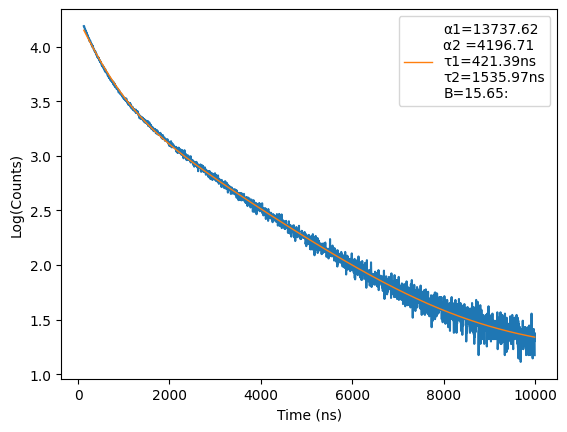

In [13]:
plt.plot(xdata,ydata)
plt.plot(xdata,model2(xdata,popt[0],popt[1],popt[2],popt[3],popt[4]),label=('\u03b11={:.2f}\n\u03b12 ={:.2f}\n\u03c41={:.2f}ns\n\u03c42={:.2f}ns\nB={:.2f}:'.format(popt[0],popt[2],popt[1],popt[3],popt[4])),linewidth=1)
#plt.yscale('log')
#plt.xscale('log')
'''print('t0='+str(popt[0]))
print('Alpha1='+str(popt[1]))
print('tau1='+str(popt[2]))
print('Alpha2='+str(popt[3]))
print('tau2='+str(popt[4]))
print('Background='+str(popt[5]))'''
plt.ylabel('Log(Counts)')
plt.xlabel('Time (ns)')
#plt.title(filename[:-4])
plt.legend()
#plt.savefig('Plots/{}.png'.format(filename))

In [305]:
popt, pcov = curve_fit(f=model1,xdata=xdata,ydata=ydata,p0=(10,300.0,400.0,10),)

t0=-107855.04558292795
Alpha1=81914.43050884553
tau1=1072.3843048971733
Alpha2=224.72773381190848


Text(0.5, 1.0, '')

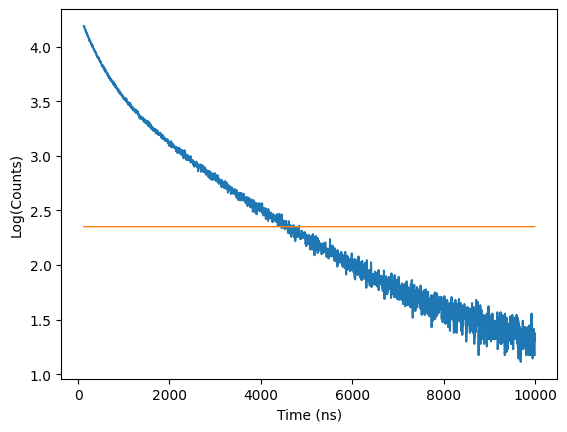

In [306]:
plt.plot(xdata,ydata)
plt.plot(xdata,model1(xdata,popt[0],popt[1],popt[2],popt[3]),linewidth=1)
#plt.yscale('log')
#plt.xscale('log')
print('t0='+str(popt[0]))
print('Alpha1='+str(popt[1]))
print('tau1='+str(popt[2]))
print('Alpha2='+str(popt[3]))

plt.ylabel('Log(Counts)')
plt.xlabel('Time (ns)')
plt.title(filename[:-4])
#plt.legend()

In [14]:
print('aldaketa')

aldaketa
